In [12]:
import os

all_files = [
    ("Text", "bert_embeddings_04sec_no_upsampled.npy", "bert_embeddings_04sec.npy"),
    ("Audio", "acoustic_scaled_56_04sec_no_upsampled.npy", "acoustic_scaled_56_04sec.npy"),
    ("Text+Audio", "combined_embeddings_04sec_no_upsampled.npy", "combined_embeddings_04sec.npy"),
]
label_files = ("labels_04sec_no_upsampled.npy", "labels_04sec.npy")

for modality, no_file, up_file in all_files:
    print(f"🔎 {modality}:")
    print(" - No Upsampling:", os.path.exists(os.path.join(base_path_no, no_file)))
    print(" - With Upsampling:", os.path.exists(os.path.join(base_path_over, up_file)))

print("\n🟢 Labels:")
print(" - No Upsampling:", os.path.exists(os.path.join(base_path_no, label_files[0])))
print(" - With Upsampling:", os.path.exists(os.path.join(base_path_over, label_files[1])))


🔎 Text:
 - No Upsampling: True
 - With Upsampling: True
🔎 Audio:
 - No Upsampling: True
 - With Upsampling: True
🔎 Text+Audio:
 - No Upsampling: True
 - With Upsampling: True

🟢 Labels:
 - No Upsampling: True
 - With Upsampling: True


In [14]:
import os

base_path_no = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_edaic"
base_path_over = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/Data_edaic"

# Define files
modality_paths = {
    "Text": ("bert_embeddings_04sec_no_upsampled.npy", "bert_embeddings_04sec.npy"),
    "Audio": ("acoustic_scaled_56_04sec_no_upsampled.npy", "acoustic_scaled_56_04sec.npy"),
    "Text+Audio": ("combined_embeddings_04sec_no_upsampled.npy", "combined_embeddings_04sec.npy"),
}
label_paths = ("labels_04sec_no_upsampled.npy", "labels_04sec.npy")

# Print modality combinations
print("🔍 Modality Embedding Paths:")
for modality, (no_file, over_file) in modality_paths.items():
    no_path = os.path.join(base_path_no, no_file)
    over_path = os.path.join(base_path_over, over_file)
    print(f"\n📁 {modality}:")
    print(f" - No Upsampling   : {no_path}")
    print(f" - With Upsampling : {over_path}")

# Print label paths
print("\n🔍 Label Paths:")
print(f" - No Upsampling   : {os.path.join(base_path_no, label_paths[0])}")
print(f" - With Upsampling : {os.path.join(base_path_over, label_paths[1])}")


🔍 Modality Embedding Paths:

📁 Text:
 - No Upsampling   : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_edaic\bert_embeddings_04sec_no_upsampled.npy
 - With Upsampling : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/Data_edaic\bert_embeddings_04sec.npy

📁 Audio:
 - No Upsampling   : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_edaic\acoustic_scaled_56_04sec_no_upsampled.npy
 - With Upsampling : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/Data_edaic\acoustic_scaled_56_04sec.npy

📁 Text+Audio:
 - No Upsampling   : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_edaic\combined_embeddings_04sec_no_upsampled.npy
 - With Upsampling : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/Data_edaic\combined_embeddings_04sec.npy

🔍 Label Paths:
 - No Upsampling   : C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_ed

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input
from tensorflow.keras.optimizers import Adam

# Base paths for upsampled and non-upsampled data
base_path_no = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_edaic"
base_path_over = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/Data_edaic"

# File names per modality
modality_paths = {
    "Text": ("bert_embeddings_04sec_no_upsampled.npy", "bert_embeddings_04sec.npy"),
    "Text+Audio": ("combined_embeddings_04sec_no_upsampled.npy", "combined_embeddings_04sec.npy"),
}
label_paths = ("labels_04sec_no_upsampled.npy", "labels_04sec.npy")

# Model definitions
def build_dense_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_1dcnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Model mapping
model_funcs = {
    "Dense": (build_dense_model, False),
    "1DCNN": (build_1dcnn_model, True),
}

# K-Fold cross-validation with printouts
def run_kfold_verbose(X, y, model_fn, is_seq, model_name, modality, upsample):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\n🟢 Fold {fold} | Model: {model_name} | Modality: {modality} | Upsampled: {upsample}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        if is_seq:
            X_train = X_train[..., np.newaxis]
            X_test = X_test[..., np.newaxis]
            model = model_fn((X.shape[1], 1))
        else:
            model = model_fn((X.shape[1],))

        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        preds = model.predict(X_test).ravel()
        pred_labels = (preds > 0.5).astype(int)

        # Print classification report
        print(classification_report(y_test, pred_labels, digits=4))

        results.append({
            "Fold": fold,
            "Model": model_name,
            "Modality": modality,
            "Upsampled": upsample,
        })

    return results

# Run all combinations
all_verbose_results = []

for modality, (no_file, over_file) in modality_paths.items():
    X_no = np.load(f"{base_path_no}/{no_file}")
    X_over = np.load(f"{base_path_over}/{over_file}")
    y_no = np.load(f"{base_path_no}/{label_paths[0]}")
    y_over = np.load(f"{base_path_over}/{label_paths[1]}")

    for model_name, (model_fn, is_seq) in model_funcs.items():
        all_verbose_results.extend(run_kfold_verbose(X_no, y_no, model_fn, is_seq, model_name, modality, False))
        all_verbose_results.extend(run_kfold_verbose(X_over, y_over, model_fn, is_seq, model_name, modality, True))




🟢 Fold 1 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9200    0.9775    0.9479      3647
           1     0.9043    0.7143    0.7981      1085

    accuracy                         0.9172      4732
   macro avg     0.9122    0.8459    0.8730      4732
weighted avg     0.9164    0.9172    0.9136      4732


🟢 Fold 2 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9241    0.9774    0.9500      3712
           1     0.8958    0.7078    0.7908      1020

    accuracy                         0.9193      4732
   macro avg     0.9099    0.8426    0.8704      4732
weighted avg     0.9180    0.9193    0.9157      4732


🟢 Fold 3 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-sc

In [13]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from scipy.stats import ttest_rel

# === Config ===
base_path_no = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/04sec_no_upsampling/Data_edaic"
base_path_over = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec/Data_edaic"
modality_paths = {
    "Text": ("bert_embeddings_04sec_no_upsampled.npy", "bert_embeddings_04sec.npy"),
    "Text+Audio": ("combined_embeddings_04sec_no_upsampled.npy", "combined_embeddings_04sec.npy"),
}
label_paths = ("labels_04sec_no_upsampled.npy", "labels_04sec.npy")
output_dir = "experiment_results"
os.makedirs(output_dir, exist_ok=True)

# === Model Definitions ===
def build_dense_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_1dcnn_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape[0], 1)),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_funcs = {
    "Dense": (build_dense_model, False),
    "1DCNN": (build_1dcnn_model, True),
}

# === Run KFold and Save Results ===
all_verbose_results = []

def run_kfold_verbose(X, y, model_fn, is_seq, model_name, modality, upsample):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\n🟢 Fold {fold} | Model: {model_name} | Modality: {modality} | Upsampled: {upsample}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        if is_seq:
            X_train = X_train[..., np.newaxis]
            X_test = X_test[..., np.newaxis]
            model = model_fn((X.shape[1], 1))
        else:
            model = model_fn((X.shape[1],))

        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        preds = model.predict(X_test).ravel()
        pred_labels = (preds > 0.5).astype(int)

        report = classification_report(y_test, pred_labels, digits=4, output_dict=True)

        results.append({
            "Fold": fold,
            "Model": model_name,
            "Modality": modality,
            "Upsampled": upsample,
            "Accuracy": report["accuracy"] * 100,
            "Precision": report["1"]["precision"] * 100,
            "Recall": report["1"]["recall"] * 100,
            "F1": report["1"]["f1-score"] * 100
        })

    return results

# Run all combinations and save metrics
for modality, (no_file, over_file) in modality_paths.items():
    X_no = np.load(f"{base_path_no}/{no_file}")
    X_over = np.load(f"{base_path_over}/{over_file}")
    y_no = np.load(f"{base_path_no}/{label_paths[0]}")
    y_over = np.load(f"{base_path_over}/{label_paths[1]}")

    for model_name, (model_fn, is_seq) in model_funcs.items():
        all_verbose_results.extend(run_kfold_verbose(X_no, y_no, model_fn, is_seq, model_name, modality, False))
        all_verbose_results.extend(run_kfold_verbose(X_over, y_over, model_fn, is_seq, model_name, modality, True))

# Save detailed results
df_results = pd.DataFrame(all_verbose_results)
df_results.to_csv(os.path.join(output_dir, "5fold_results.csv"), index=False)

# === Post-analysis: Improvements & P-values ===
improvements = []
p_values = []
metrics = ["Accuracy", "Precision", "Recall", "F1"]

for model in df_results["Model"].unique():
    for modality in df_results["Modality"].unique():
        for metric in metrics:
            base = df_results[(df_results["Model"] == model) & (df_results["Modality"] == modality) & (df_results["Upsampled"] == False)][metric].values
            up = df_results[(df_results["Model"] == model) & (df_results["Modality"] == modality) & (df_results["Upsampled"] == True)][metric].values
            if len(base) == len(up) == 5:
                improvement = (up - base).mean()
                stat, p = ttest_rel(up, base)

                improvements.append({
                    "Model": model,
                    "Modality": modality,
                    "Metric": metric,
                    "Improvement (points)": round(improvement, 2)
                })
                p_values.append({
                    "Model": model,
                    "Modality": modality,
                    "Metric": metric,
                    "p-value": round(p, 6)
                })

# Save post-analysis results
pd.DataFrame(improvements).to_csv(os.path.join(output_dir, "upsampling_improvement.csv"), index=False)
pd.DataFrame(p_values).to_csv(os.path.join(output_dir, "upsampling_pvalues.csv"), index=False)

print("✅ All results saved to:", output_dir)



🟢 Fold 1 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 2 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 3 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 4 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 5 | Model: Dense | Modality: Text | Upsampled: False
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 1 | Model: Dense | Modality: Text | Upsampled: True
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 2 | Model: Dense | Modality: Text | Upsampled: True
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 3 | Model: Dense | Modality: Text | Upsampled: True
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 4 | Model: Dense | Modality: Text | Upsampled: True
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🟢 Fold 5 | Model: Dense | Modality: Text | Upsampled: True
148/148 ━━━━━━━━━━━━━━━━━━

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14960\3842776336.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


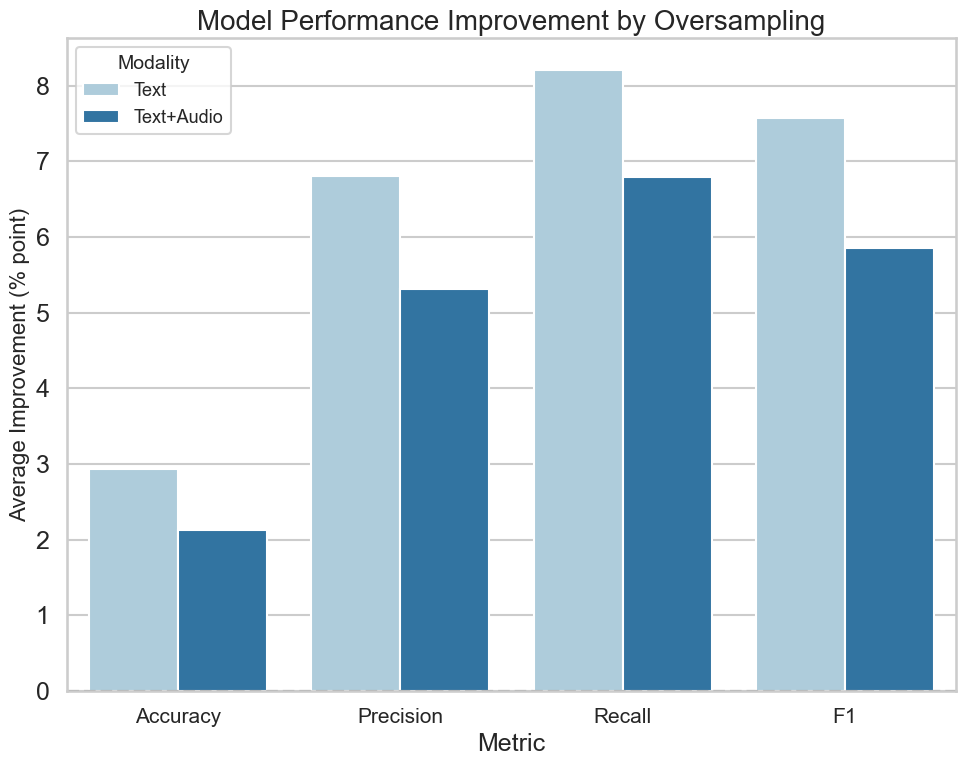

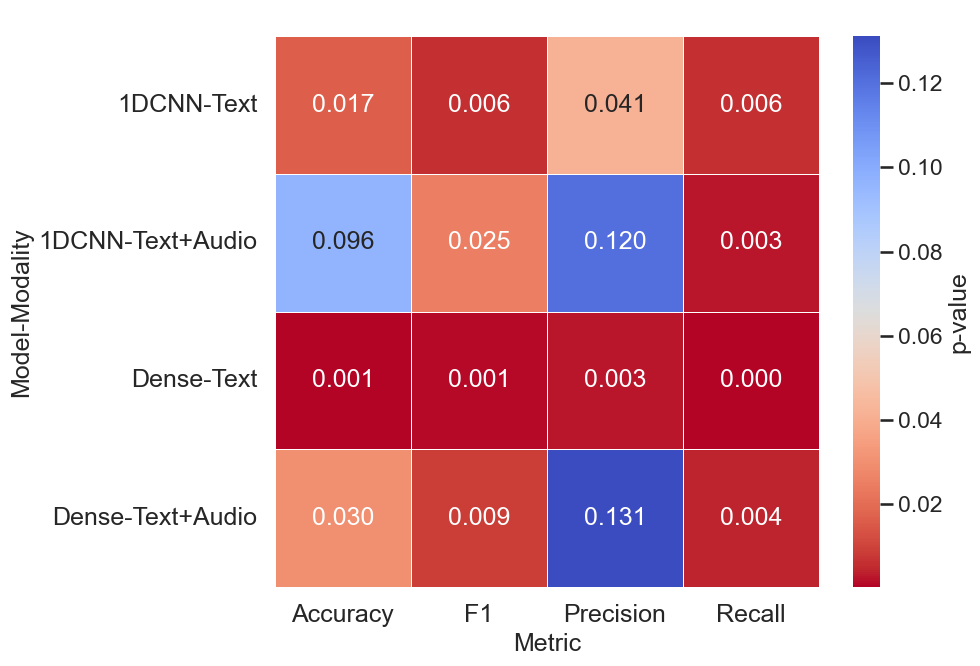

In [7]:
# Merge and annotate
summary_df = pd.merge(improvement_df, pvalues_df, on=["Model", "Modality", "Metric"])
summary_df["Annotated"] = summary_df.apply(
    lambda row: f"{row['Improvement (points)']:.2f}" + ("*" if row["p-value"] < 0.05 else ""), axis=1
)

# Update with larger fonts and a different bar color palette
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.set_context("talk")  # Use larger font context

# Use a new color palette: 'Paired'
sns.barplot(
    data=summary_df,
    x="Metric",
    y="Improvement (points)",
    hue="Modality",
    palette="Paired",
    ci=None
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Model Performance Improvement by Oversampling", fontsize=20)
plt.ylabel("Average Improvement (% point)", fontsize=16)
plt.xlabel("Metric", fontsize=18)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=18)
plt.legend(title="Modality", fontsize=13, title_fontsize=14)
plt.tight_layout()
plt.savefig("/mnt/data/improvement_barplot_v2.png", dpi=300)
plt.show()

# 🔥 Heatmap
heatmap_df = summary_df.pivot_table(index=["Model", "Modality"], columns="Metric", values="p-value")

plt.figure(figsize=(10, 7))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap="coolwarm_r",
    linewidths=0.5,
    cbar_kws={'label': 'p-value'}
)
plt.title(" ", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("pvalues_heatmap.png", dpi=300)
plt.show()

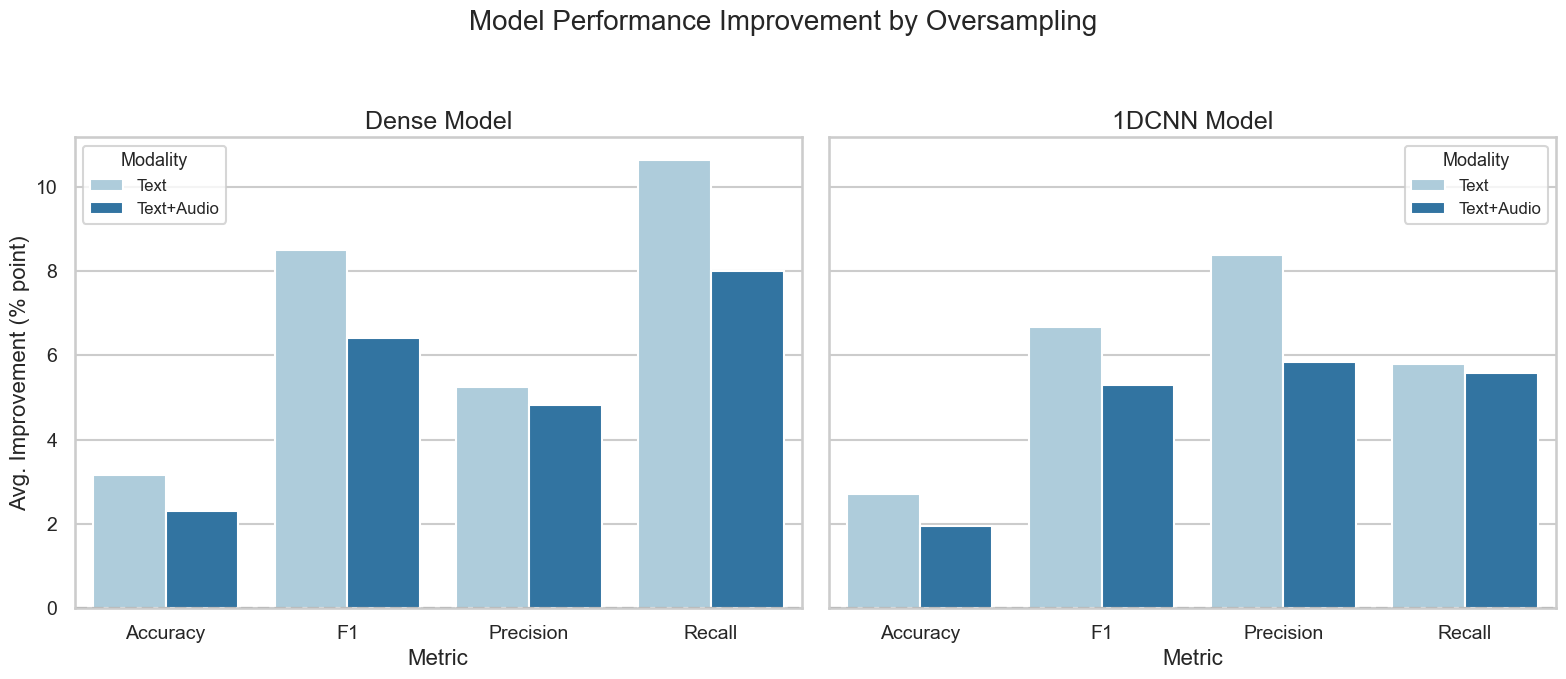

✅ Plot saved to: C:/Users/Administrator/PycharmProjects/Comprehensive/04sec_edaic/experiment_results/improvement_barplot_split.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load improvements and p-values (update paths as needed)
improvement_df = pd.read_csv("C:/Users/Administrator/PycharmProjects/Comprehensive/04sec_edaic/experiment_results/upsampling_improvement.csv")
pvalues_df = pd.read_csv("C:/Users/Administrator/PycharmProjects/Comprehensive/04sec_edaic/experiment_results/upsampling_pvalues.csv")

# Prepare improvement data for plotting
improvement_df = improvement_df.pivot_table(index=["Model", "Modality"], columns="Metric", values="Improvement (points)").reset_index()
improvement_df = improvement_df.melt(id_vars=["Model", "Modality"], var_name="Metric", value_name="Improvement (points)")

# Merge p-values and annotate significance
summary_df = pd.merge(improvement_df, pvalues_df, on=["Model", "Modality", "Metric"])
summary_df["Annotated"] = summary_df.apply(
    lambda row: f"{row['Improvement (points)']:.2f}" + ("*" if row["p-value"] < 0.05 else ""), axis=1
)

# Plot settings
sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Draw separate bar plots for Dense and 1DCNN
for ax, model in zip(axes, ["Dense", "1DCNN"]):
    model_data = summary_df[summary_df["Model"] == model]
    sns.barplot(
        data=model_data,
        x="Metric",
        y="Improvement (points)",
        hue="Modality",
        palette="Paired",
        ax=ax
    )
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title(f"{model} Model", fontsize=18)
    ax.set_xlabel("Metric", fontsize=16)
    ax.set_ylabel("Avg. Improvement (% point)" if model == "Dense" else "", fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(title="Modality", fontsize=12, title_fontsize=13)

# Global title and layout
plt.suptitle("Model Performance Improvement by Oversampling", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show
output_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/04sec_edaic/experiment_results/improvement_barplot_split.png"
plt.savefig(output_path, dpi=300)
plt.show()

print(f"✅ Plot saved to: {output_path}")
